# Introduction

This tutorial will introduce you to Bayesian Networks, a type of probabilistic graphical model. We will go over the key components of the model as well as implement a couple examples. Bayesian Networks are incredibly useful for data science and machine learning. Bayesian Networks allow us to understand dependency among events, and this implies we can assess how a change in the state of one event can influence another. We can also make predictions from Bayesian Networks given various inference techniques. Since Bayesian Networks do encompass graphs, it is often helpful to visualize the graph structure along with the respective distribution tables or distribution functions of each node. Please note that this tutorial is no where near a comprehensive overview of Bayesian Networks; rather, it focuses on introducing a new method that might be helpful for those with interest in machine learning and data science. Also, to understand the following sections, it is only assumed that reader has knowledge of basic probablitiy concepts.

### Tutorial Content

We will learn what is a Bayesian Network, what are the assumptions of Bayesian Networks, how can we create a structure and identify parameters for a Bayesian network given we have prior knowledge of both, how can we learn both the structure and parameters for a Bayesian Network given data alone, and assess an inference method on our Bayesian Network model. 

We will be using pgmpy, a python library for probablistic graphical models, to do so. Here is the documentation: http://pgmpy.org

This is a breakdown of the aforementioned topics coverd in the tutorial:

- Installing libraries
- What are Bayesian Networks
- Implement a Bayesian Network with prior knowledge of structure and parameters
- Visualizing a Bayesian Network
- Loading and Preprocessing Dataset
- Fitting a Bayesian Network to a Dataset
- Fitting a Bayesian Network to the Flags Dataset with prior knowledge of structure
- Prediction and Inference on Bayesian Networks
- Concluding Remarks
- Further Resources and References

# Installing Libraries

Here is the link for assistance with installing pgmpy and its dependencies: https://github.com/pgmpy/pgmpy

Type the following command using pip to install the necessary libaries: <br>
$ pip install -r requirements.txt

Makes sure you are able to import the following:

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import collections
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from IPython.display import Image
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.model_selection import train_test_split
from pgmpy.factors.discrete import TabularCPD

# What are Bayesian Networks

This is a quick mathematical and statistical overview for concepts in Bayesian Networks. For ease, we will divide into the following subsections:
- Relevant probability concepts
- Probabilisitic Graphical Models
- Bayesian Assumptions
- Bayesian Networks

### Relevant Probability Concepts
(we will focus on the discrete case (i.e. considero only discrete random variables))

__Joint probability mass function (or a multivariate mass distribution)__ : Probability that two or more events are occuring simultaneoulsy

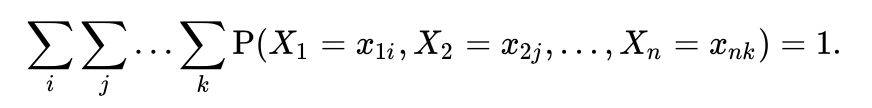

In [2]:
Image(filename='jpmf.png')

__Marginal probability__: Hold the probablity of interest $(X=D)$ constant while iterating over all other random variables and summing their joint probabilities

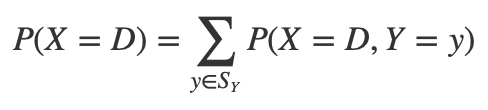

In [3]:
Image(filename='marginal.png')

__Conditional probability__: Probability of an event $X$ occurring when a secondary event $Y$ is true

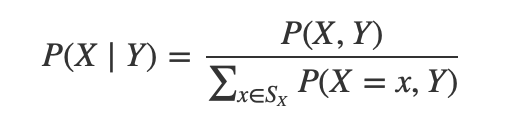

In [4]:
Image(filename='conditional.png')

Observe that in the equation above, the conditional probability $P(X | Y)$ is mathematically related to the joint probability $P(X, Y)$ and the marginal probability $P(Y)$ (in the denominator).

### Probabilistic Graphical Models

#### Probabilistic Graphical Models provide a way to minimize the cost of representing a joint distribution by adding a structure to a multivariate statistical distribution. 

For example, if we wanted to represent the full joint distribution of $n$ random variables, we would need $2^n$-1 parameters. A probabilistic graphical model constrains the conditional dependencies among random variables such that the number of parameters is often linear with respect to the number of random variables. However, we still need to make sure any previously known independence relationships in the distribution are still compatible. Overall, this methodology allows us to succintly represent a joint distribution. Other benefits include that the joint distribution becomes *modularized*, meaning it can be factored into smaller mathematical components, thereby making calculations easier. 


### Bayesian Methodology

Reminder that __Bayes Rule__ is as follows: we calculate the likelihood of $P(d|h)$ using the posterior $p(h|d)$ and some prior knowledge $p(h)$.

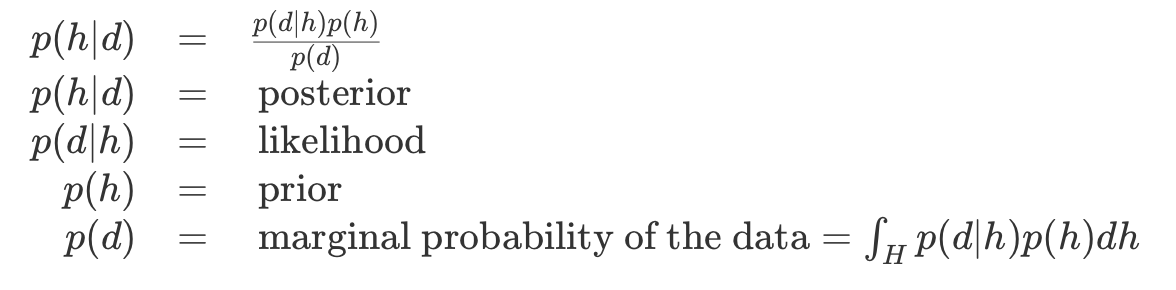

In [5]:
Image(filename='bayesr.png')

One of the most common relationships assumed in many Bayesian problems is __conditional independence__.
Conditional independence is defined as X is conditionally independent of Y given Z iff the probablity distribution governing X is independent of Y, given the value of Z. This can be written mathematically as, $\forall (x, y, z)$:  $P(X=x|Y=y,Z=z)$ = $P(X=x|Z=z)$.

### Bayesian Networks

__A Bayesian network is a directed, acyclic graph, whose nodes represent random variables and directed edges represent causality relationships between nodes.__ <br> <br> Each node $X_i$ asserts the following conditional independence assumption: <br> <br>
{${X_i \perp NonDescendants_{X_i} | Parents_{X_i}}$} <br> <br>
In words, a node is conditionally independent of its ancestors given its parents. This implies each node is a stochastic function of its parents. <br> <br>
Since each node represents a random variable which has some probability distribution, the whole graph is a joint probability distribution and can be *written in factorized forms because of the conditional independencies* between variables. Given discrete random variables at each node, the factorized form is a *conditional probability table*. Note: we will often use the terms node and random variable interchangeably throughout the tutorial. <br> <br>

Here is just a quick reference for factorizing a joint probability distribution from a Bayesian Network using the conditional independence assumption detailed above. We will go over this in a specific example shortly.

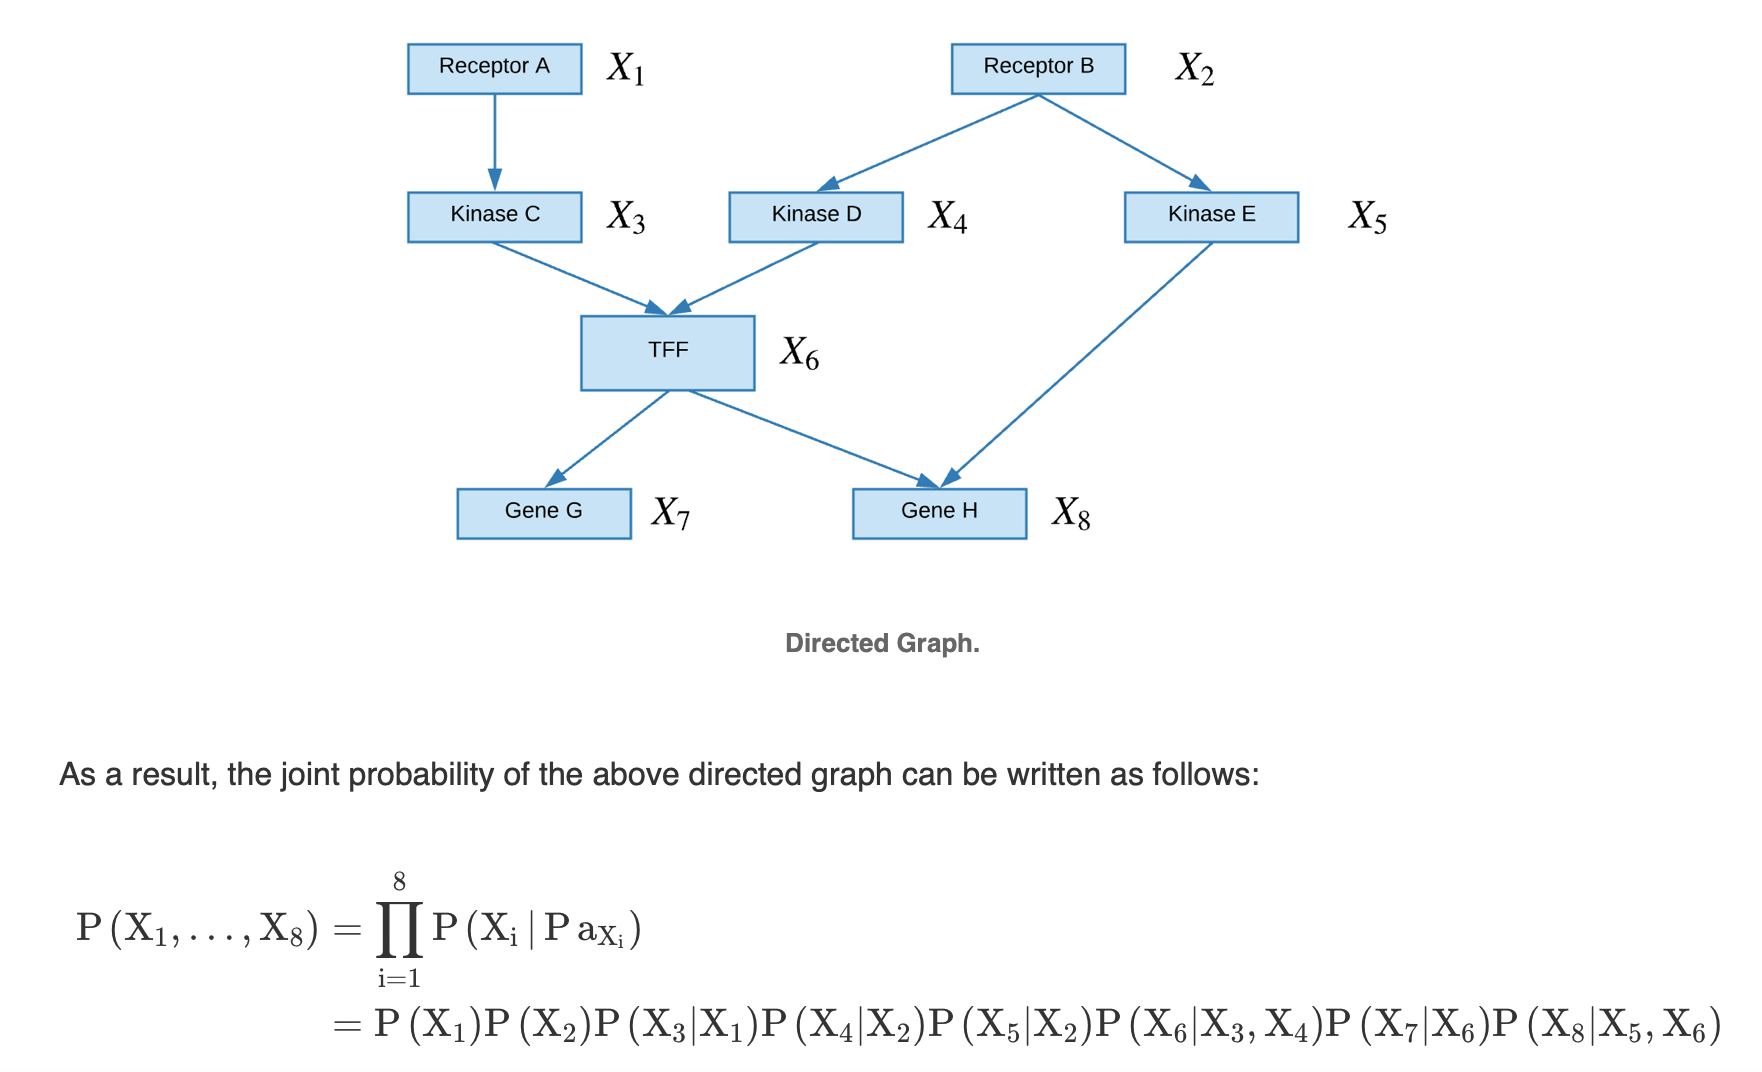

In [6]:
Image(filename='factorization.png')

#### Learning Bayesian Networks

There are two components to specify a Bayesian Network: <br> 
- Graph __Structure__: the topology of the nodes and edges (qualitative)
- __Parameters__: the numbers of a conditional distribution at each node (quantitative)
<br> <br>
We will first walk through an example where both the structure and parameters of a Bayesian Network are known. We will later walk through an example where neither the structure nor the parameters are known, and we first determine the structure then the parameters.

# Implement a Bayesian Network with prior knowledge of structure and parameters

Suppose we are looking at dataset that assesses heart health state based on the following variables: Exercise, Smoking (Smokes node in graph below), Blood Pressure (BP), Cholesterol (Chol), and Heart Attack (Attack). We isolate the following causal relations: Exercise influences Blood Pressure, Smoking influences BP and Cholesterol, and BP influences Heart Attack. Observe that these are all discrete random variables with a binary outcome: T or F. We draw out these relations in a graph structure. <br> <br>
Now, we also know the joint probability distribution from the dataset, and since we are studying a small number of random variables, we can (kind of) easily retrieve the conditional probability tables for each node. <br> <br>
We have a structure and parameters of a Bayesian Network, specified below.

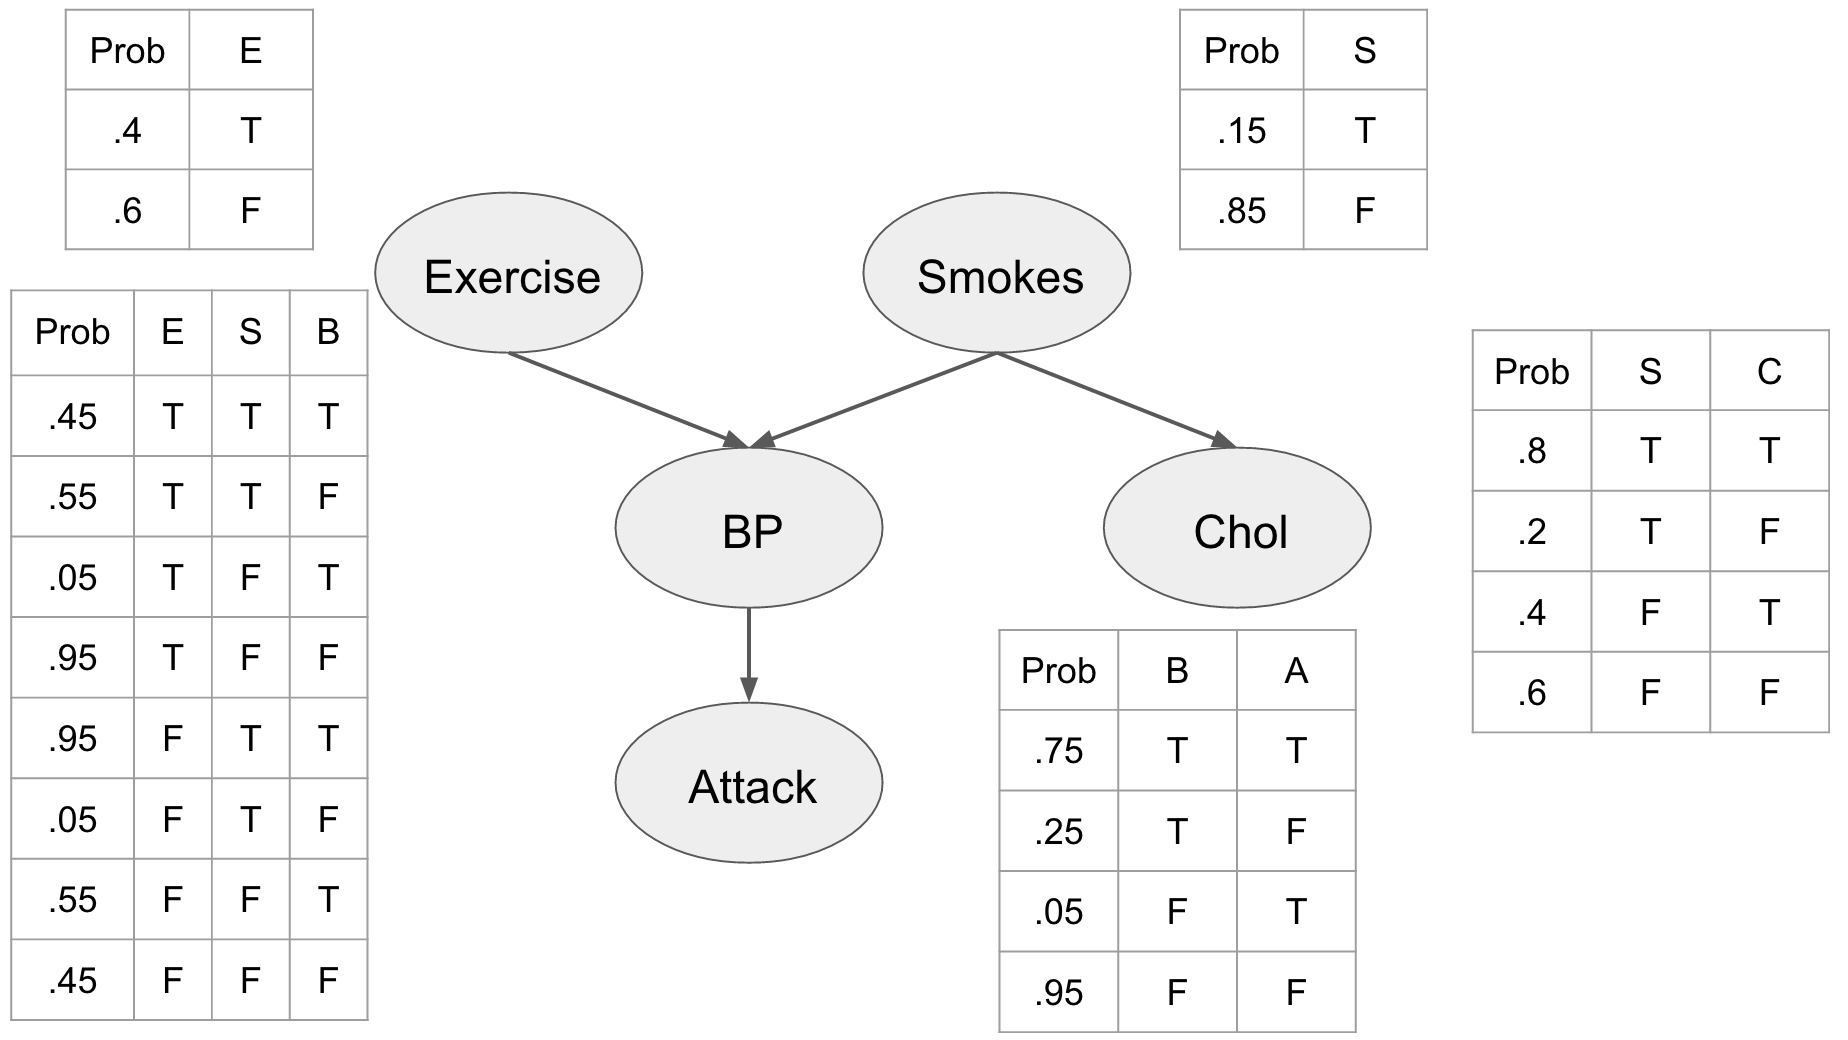

In [7]:
Image(filename='smoking.png')

Just having a Bayesian Network is not enough! Say we want to do further calculations on this model; we will use pgmpy to actually implement this Bayesian Network. <br>

To start, we will define the structure of our model by adding the nodes and edges to a Bayesian Model instance. By adding the directed edges, we are also predefining the nodes in the model. Here, we abbreviate the nodes: E for Excercise, B for BP, S for Smokes, C for Chol, and A for Attack.

In [8]:
heart_model = BayesianModel([('E', 'B'), 
                              ('S', 'B'),
                              ('S', 'C'),
                              ('B', 'A')])

We can make a call to get all the local independencies in the network. Again, this follows the conditional independence assumption that a node is independent of its nondescendants given its parents.

In [9]:
heart_model.local_independencies(['E', 'B', 'S', 'C', 'A'])

(E _|_ S, C)
(B _|_ C | E, S)
(S _|_ E)
(C _|_ E, B, A | S)
(A _|_ E, S, C | B)

Using the local independencies, we can  rewrite the conditional probability distributions (CPD) of all nodes in the graph: <br>

Observe that since ($E \perp C, S$), the conditional probability at node E is just $P(E)$. Likewise, since ($B \perp C | E, S$) the conditional probability at node B is $P(B | E, S)$. <br>

We can now rewrite the *joint probability of the whole graph* as the product of CPDs: <br>
$P(E, B, S, C, A)$ = $P(E) * P(B | E, S) * P(S) * P(C| S) * P(A| B)$ and this is under the conditional independence assumption <br>
As a side note, we can also arrive at the joint probability of the whole graph by applying the chain rule of probability and then the conditional independence assumption.

Now, we will define the parameters for our model. We will start by defining the easier conditional probability tables for nodes that have no parents. When we call TabularCPD to create a conditional probablity table for a node, we specify the node in argument *variable*, we specify the cardinality or number of discrete values this node has in argument *variable_card*, and then we specify the conditional probability table values in argument *values*.

In [10]:
cpd_E = TabularCPD(variable='E', variable_card=2,
                      values=[[0.4], [0.6]]) #defining T first
cpd_S = TabularCPD(variable='S', variable_card=2,
                      values=[[0.15], [0.85]]) #defining T first
print(cpd_E)
print(cpd_S)

+------+-----+
| E(0) | 0.4 |
+------+-----+
| E(1) | 0.6 |
+------+-----+
+------+------+
| S(0) | 0.15 |
+------+------+
| S(1) | 0.85 |
+------+------+


Now we need to define the parameters for our other variables. Let's look at node B. Since B has parents, we specify its parents as the argument *evidence*, and we specify the cardinality of the evidence as the argument *evidence_card*. Given two random variables with binary outcomes, the cardinaltiy of evidence is 2x2. Also, we can specify the values random variables take on using argument *state_names*. Observe that the best way to figure out how values are stored in a conditional probability distribution for a node is to print it out. When inputting values, be careful because there are discrepancies between the original table in the picture above and pgmpy's default table. Here we can see that the domain of values for the current node we are assessing appears in the rows of the CPD while the evidence appears in the columns of the CPD.

In [11]:
cpd_B = TabularCPD(variable='B', variable_card=2, 
                   values=[[0.45, 0.05, 0.95,  0.55],
                           [0.55, 0.95, 0.05, 0.45]],
                  evidence=['E', 'S'],
                  evidence_card=[2, 2],
                  state_names={'B': ['T', 'F'],
                                   'E': ['T', 'F'],
                                   'S': ['T', 'F']})
print(cpd_B)

+------+------+------+------+------+
| E    | E(T) | E(T) | E(F) | E(F) |
+------+------+------+------+------+
| S    | S(T) | S(F) | S(T) | S(F) |
+------+------+------+------+------+
| B(T) | 0.45 | 0.05 | 0.95 | 0.55 |
+------+------+------+------+------+
| B(F) | 0.55 | 0.95 | 0.05 | 0.45 |
+------+------+------+------+------+


We repeat the above process to specify the CPDs for nodes C and A.

In [12]:
cpd_C = TabularCPD(variable='C', variable_card=2,
                      values=[[0.8, 0.4],
                              [0.2, 0.6]],
                      evidence=['S'],
                      evidence_card=[2])

cpd_A = TabularCPD(variable='A', variable_card=2, 
                   values=[[0.75, 0.05],
                           [0.25, 0.95]],
                   evidence=['B'],
                   evidence_card=[2])

print(cpd_C)
print(cpd_A)

+------+------+------+
| S    | S(0) | S(1) |
+------+------+------+
| C(0) | 0.8  | 0.4  |
+------+------+------+
| C(1) | 0.2  | 0.6  |
+------+------+------+
+------+------+------+
| B    | B(0) | B(1) |
+------+------+------+
| A(0) | 0.75 | 0.05 |
+------+------+------+
| A(1) | 0.25 | 0.95 |
+------+------+------+


Now we associate the conditional probablility distributions with our model, and check that the parameter and structure hold. For the parameters, we want to verify that all the CPDs sum to 1. For the structure, we want to make sure we have a directed, acyclic graph.

In [13]:
heart_model.add_cpds(cpd_E, cpd_S, cpd_B, cpd_A, cpd_C)
heart_model.check_model()

True

# Visualizing a Bayesian Network

We will do a very naive visualization of our small Bayesian Network using Networkx, which uses matplotlib for the visualization. We want to recreate our Bayesian Network structure in a Networkx graph; we start by creating an directed graph object.

In [14]:
G = nx.DiGraph()

We populate the empty directed graph with the intended edges and nodes, then check that it is a DAG.

In [15]:
for item in list(heart_model.edges()):
    G.add_edge(item[0], item[1])
for item in list(heart_model.nodes()):
    G.add_node(item)

nx.is_directed_acyclic_graph(G)

True

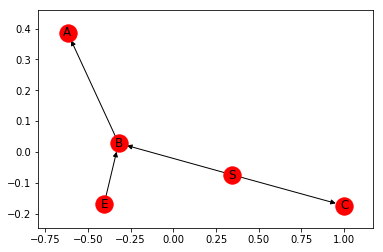

In [16]:
nx.draw_networkx(G)

Observe that while this may not be as nice an image as the structure we started with from prior knowledge, it is still helpful to reaffirm that we did recreate the structure properly.

# Loading and Preprocessing Dataset

We will now be implementing another Bayesian Network, except in this case, we start with neither prior knowledge of the parameters nor graph structure. We will start by preprocessing the data using pandas. Here are a couple key notes about the data: <br>
- No missing values
- 193 examples and 30 attributes
- 10 of the 30 attributes are continuous variables; we will either drop them or convert them to discrete variables
<br> <br>
The link to UCI ML Repository Flags Data Set is in the last Section of the tutorial under resources; it may be helpful to view it viewing how the attributes are encoded. <br>
We read in the data set and specify the column names.

In [17]:
df = pd.read_csv("flag.data") 

In [18]:
df.columns = ['name', 'landmass', 'zone', 'area', 'population', 'language', 'religion', 'bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses', 'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text', 'topleft', 'botright']

Our goal is to have a dataset of only discrete random variables. We choose to keep 8 of the continous attributes and drop 2 of them. If we choose to keep a continous attribute, we will replace the numeric value with a discrete factor based on the domain of numeric values (the numeric values are all integers). Here is what we will do for the following continous attributes: <br>
- area: Drop Column
- population: Drop Column
- bars: "a" if 0, "b" if 1 to 2, "c" if 3 or greater
- stripes: "a" if 0, "b" if 1 to 2, "c" if 3, "d" if 4 to 7, "e" if 8 or greater
- colours: "a" if 1, "b" if 2, "c" if 3, "d" if 4, "e" if 5, "f" if 6 or greater
- circles: "a" if 0, "b" if 1, "c" if 2 or greater
- crosses: "a" if 0, "b" if 1, "c" if 2 or greater
- saltires: "a" if 0, "b" if 1 or greater
- quarters: "a" if 0, "b" if 1, "c" if 2 or greater
- sunstars: "a" if 0, "b" if 1, "c" if 2 to 5, "d" if 6 to 15, "e" if 15 or greater

Note that this discretization is subjective and naive; I did it by separating notably different counts for sequential continous variables into separate groups.

In [19]:
print("replace bars")
print((collections.Counter(df.loc[:, "bars"])))

arr = (df.loc[:,'bars']).tolist()
for i in range(len(arr)):
    if (arr[i] == 0): arr[i] = "a"
    elif (arr[i] >= 3): arr[i] = "c"
    else: arr[i] = "b"
df['bars'] = arr

replace bars
Counter({0: 158, 3: 21, 2: 7, 1: 6, 5: 1})


In [20]:
print("replace stripes")
print(collections.Counter(df.loc[:, "stripes"]))

arr = (df.loc[:,'stripes']).tolist()
for i in range(len(arr)):
    if (arr[i] == 0): arr[i] = "a"
    elif (arr[i] >= 1 and arr[i] <= 2): arr[i] = "b"
    elif (arr[i] == 3): arr[i] = "c"
    elif (arr[i] >= 4 and arr[i] <= 7): arr[i] = "d"
    else: arr[i] = "e"
df['stripes'] = arr

replace stripes
Counter({0: 110, 3: 43, 2: 16, 5: 12, 1: 4, 9: 2, 11: 1, 14: 1, 4: 1, 6: 1, 13: 1, 7: 1})


In [21]:
print("replace colours")
print(collections.Counter(df.loc[:, "colours"]))

arr = (df.loc[:,'colours']).tolist()
for i in range(len(arr)):
    if (arr[i] == 1): arr[i] = "a"
    elif (arr[i] == 2): arr[i] = "b"
    elif (arr[i] == 3): arr[i] = "c"
    elif (arr[i] == 4): arr[i] = "d"
    elif (arr[i] == 5): arr[i] = "e"
    else: arr[i] = "f"
df['colours'] = arr

replace colours
Counter({3: 75, 4: 44, 2: 42, 5: 14, 6: 9, 7: 7, 8: 1, 1: 1})


In [22]:
print("replace circles")
print(collections.Counter(df.loc[:, "circles"]))

arr = (df.loc[:,'circles']).tolist()
for i in range(len(arr)):
    if (arr[i] == 0): arr[i] = "a"
    elif (arr[i] == 1): arr[i] = "b"
    else: arr[i] = "c"
df['circles'] = arr

replace circles
Counter({0: 164, 1: 27, 4: 1, 2: 1})


In [23]:
print("replace crosses")
print(collections.Counter(df.loc[:, "crosses"]))

arr = (df.loc[:,'crosses']).tolist()
for i in range(len(arr)):
    if (arr[i] == 0): arr[i] = "a"
    elif (arr[i] == 1): arr[i] = "b"
    else: arr[i] = "c"
df['crosses'] = arr

replace crosses
Counter({0: 166, 1: 25, 2: 2})


In [24]:
print("replace saltires")
print(collections.Counter(df.loc[:, "saltires"]))

arr = (df.loc[:,'saltires']).tolist()
for i in range(len(arr)):
    if (arr[i] == 0): arr[i] = "a"
    else: arr[i] = "b"
df['saltires'] = arr

replace saltires
Counter({0: 175, 1: 18})


In [25]:
print("replace quarters")
print(collections.Counter(df.loc[:, "quarters"]))

arr = (df.loc[:,'quarters']).tolist()
for i in range(len(arr)):
    if (arr[i] == 0): arr[i] = "a"
    elif (arr[i] == 1): arr[i] = "b"
    else: arr[i] = "c"
df['quarters'] = arr

replace quarters
Counter({0: 167, 1: 25, 4: 1})


In [26]:
print("replace sunstars")
print(collections.Counter(df.loc[:, "sunstars"]))

arr = (df.loc[:,'sunstars']).tolist()
for i in range(len(arr)):
    if (arr[i] == 0): arr[i] = "a"
    elif (arr[i] == 1): arr[i] = "b"
    elif (arr[i] >= 2 and arr[i] <= 5): arr[i] = "c"
    elif (arr[i] >= 6 and arr[i] <= 15): arr[i] = "d"
    else: arr[i] = "e"
df['sunstars'] = arr

replace sunstars
Counter({0: 114, 1: 49, 5: 7, 2: 6, 4: 5, 6: 2, 3: 2, 7: 2, 22: 1, 14: 1, 15: 1, 10: 1, 9: 1, 50: 1})


We retrieve all the country names. Since each is unique, this would not provide any importance as a feature.

In [27]:
df_labels = df.loc[:,'name']

In [28]:
df = df.drop(columns=['name', 'area', 'population'])

Here is a view of the cleaned data table.

In [29]:
df.head(n=15)

,landmass,zone,language,religion,bars,stripes,colours,red,green,blue,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,3,1,6,6,a,a,c,1,0,0,...,a,a,b,0,0,0,1,0,red,red
1,4,1,8,2,b,a,c,1,1,0,...,a,a,b,1,0,0,0,0,green,white
2,6,3,1,1,a,a,e,1,0,1,...,a,a,a,0,1,1,1,0,blue,red
3,3,1,6,0,c,a,c,1,0,1,...,a,a,a,0,0,0,0,0,blue,red
4,4,2,10,5,a,b,c,1,0,0,...,a,a,b,0,0,1,0,0,red,black
5,1,4,1,1,a,b,c,0,0,1,...,a,a,a,0,0,0,1,0,white,blue
6,1,4,1,1,a,b,e,1,0,1,...,a,a,b,0,1,0,0,0,black,red
7,2,3,2,0,a,c,b,0,0,1,...,a,a,a,0,0,0,0,0,blue,blue
8,2,3,2,0,a,c,c,0,0,1,...,a,a,b,0,0,0,0,0,blue,blue
9,6,2,1,1,a,a,c,1,0,1,...,b,b,d,0,0,0,0,0,white,blue


Since we dropped 3 attributes, we should have 30-3=27 now.

In [30]:
df.shape

(193, 27)

Lastly, we will split our data into a training and testing set. We will fit a Bayesian Network on the training set, and then we will make some predictions on the testing set. Even though we call these training and testing, they are different from machine learning notions of training and testing because we do not really have any class of labels we want to predict for each flag example. We will just be exploring conditional predictions we can make from our Bayesian Network.

In [31]:
xTrain, xTest, yTrain, yTest = train_test_split(df, df_labels, test_size = 0.1, random_state = 0) #we set seed to 0

In [32]:
xTrain.head()

,landmass,zone,language,religion,bars,stripes,colours,red,green,blue,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
33,4,1,10,5,b,a,e,1,1,1,...,a,a,b,0,0,0,0,0,blue,gold
86,3,1,6,0,c,a,c,1,1,0,...,a,a,a,0,0,0,0,0,green,red
106,4,4,3,2,c,a,c,1,1,0,...,a,a,a,0,0,0,0,0,green,red
153,5,1,10,7,a,a,d,1,0,1,...,a,a,a,0,0,1,0,0,white,white
66,3,4,1,1,a,b,c,1,0,0,...,a,a,a,0,0,1,0,0,white,red


In [33]:
xTrain.shape

(173, 27)

In [34]:
xTest.head()

,landmass,zone,language,religion,bars,stripes,colours,red,green,blue,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
111,1,4,2,0,c,a,d,1,1,0,...,a,a,a,0,0,0,1,0,green,red
134,2,3,2,0,a,c,f,1,1,1,...,a,a,b,0,0,1,1,1,red,blue
44,3,1,5,6,a,a,c,1,0,1,...,a,a,a,0,1,0,0,0,white,red
123,1,4,2,0,a,c,b,0,0,1,...,a,a,a,0,0,0,0,0,blue,blue
158,1,4,1,1,a,a,e,1,1,0,...,a,a,c,0,1,0,0,0,green,red


In [35]:
xTest.shape

(20, 27)

Just to reiterate that this is not a classification task; we will not be using yTrain or yTest for predictions. We merely have them as fillers to compute *train_test_split*. We have 20 examples in our testing set and 173 in our training set.

# Fitting a Bayesian Network to a Dataset

Unlike before with the heart_model, we have neither prior knowledge of the graph structure nor its parameters. The first step we need to take is to learn the model structure from the data. That is, we need to identify a directed, acyclic graph (DAG) that has enough variables to approximate the causal relationships in the data. There are two main techniques to do so: <br>
1. score-based structure learning
2. constraint-based structure learning

At a high-level, score-based algorithms optimize objective functions where each candidate DAG is assigned a network score based on some scoring technique. Constraint-based algorithms use statistical tests to identify conditional independence relations, and connects nodes that are not identified as independent. <br>

We will proceed with a score-based algorithm called Hill Climb Search to learn the DAG. HillClimbSearch is a greedy algorithm that achieves a local maxima by 1. starting with empty DAG, 2. iteratively adding an edge at a time, and 3. assessing the score. The scoring method we will use is a BIC score. BIC measures how much a given node is influenced by potential parents.

### Learning Structure

We initialize the Hill Climb Search algorithm with our training data and the BIC scoring method. We store the structure in *flags_structure*, a Bayesian Model instance.

In [36]:
est = HillClimbSearch(xTrain, scoring_method=BicScore(xTrain))
flags_structure = est.estimate()
print("done")

done


In [37]:
(flags_structure.nodes())

NodeView(('landmass', 'zone', 'language', 'religion', 'bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses', 'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text', 'topleft', 'botright'))

We see which features, if any, are eliminated from the graph structure:

In [38]:
set(df.columns) - set(flags_structure.nodes())

set()

It appears that all features are represented as nodes in our graph structure. Now, we study the edges:

In [39]:
flags_structure.edges()

OutEdgeView([('landmass', 'religion'), ('zone', 'landmass'), ('zone', 'language'), ('colours', 'gold'), ('colours', 'black'), ('green', 'orange'), ('blue', 'topleft'), ('blue', 'mainhue'), ('blue', 'white'), ('blue', 'crosses'), ('white', 'gold'), ('black', 'triangle'), ('black', 'icon'), ('black', 'crescent'), ('orange', 'animate'), ('mainhue', 'red'), ('crosses', 'saltires'), ('saltires', 'quarters'), ('saltires', 'orange'), ('animate', 'icon'), ('animate', 'colours'), ('animate', 'text'), ('botright', 'blue'), ('botright', 'green')])

We definitely do not have a complete graph or "nearly" complete graph where all features are identified as having causal relationships to one another. Perhaps our Hill Climb Search Algorithm has succeeded in identifying some causal relationships.

### Learning Parameters

Now that we have a DAG structure, we want to learn the parameters of each node. That is, we want to pick probability estimates for all random variables. Two ways we can do this: <br>
1. Maximum Likelihood Estimation (MLE)
2. Bayesian Estimation

The (MLE) approach fills CPDs to maximize $P(data|model)$ using relative frequencies. On the other hand, Bayesian  Estimation starts with existing prior CPDs which are then updated with state counts from the data. I will proceed by using the MLE estimation for parameters, mainly because determining appropriate prior CPDs and state counts is a challenging task and whole other adventure into Bayesian statistics.

We create a Bayesian Model from our graph structure in *flags_structure*. Even though documentation indicates *flags_structure* should be a Bayesian model instance, it appears to be of type "pgmpy dag". So, we just populate a Bayesian Model instance *flags_BN* with all the edges (and thereby also adding the nodes)  from *flags_structure*. Then, we fit that model to our data.

In [40]:
flags_BN = BayesianModel(list(flags_structure.edges()))
flags_BN.fit(xTrain, estimator=MaximumLikelihoodEstimator)
print("done")

done


Nowe we have a list of all the CPDs for our model.

In [41]:
flags_BN.get_cpds()

[<TabularCPD representing P(animate:2 | orange:2) at 0x1c1ead8940>,
 <TabularCPD representing P(black:2 | colours:6) at 0x1c206b1160>,
 <TabularCPD representing P(blue:2 | botright:8) at 0x1c206c62b0>,
 <TabularCPD representing P(botright:8) at 0x1c206a2c88>,
 <TabularCPD representing P(colours:6 | animate:2) at 0x1c206dab70>,
 <TabularCPD representing P(crescent:2 | black:2) at 0x1c206da828>,
 <TabularCPD representing P(crosses:3 | blue:2) at 0x1c2071c198>,
 <TabularCPD representing P(gold:2 | colours:6, white:2) at 0x1c2071cac8>,
 <TabularCPD representing P(green:2 | botright:8) at 0x1c206da7b8>,
 <TabularCPD representing P(icon:2 | animate:2, black:2) at 0x1c2071c208>,
 <TabularCPD representing P(landmass:6 | zone:4) at 0x1c2071ce48>,
 <TabularCPD representing P(language:10 | zone:4) at 0x1c2071cb00>,
 <TabularCPD representing P(mainhue:8 | blue:2) at 0x1c2071ccf8>,
 <TabularCPD representing P(orange:2 | green:2, saltires:2) at 0x1c2071cd68>,
 <TabularCPD representing P(quarters:3 |

In [42]:
flags_BN.local_independencies(['religion', 'landmass', 'red'])

(religion _|_ zone, mainhue, language, red, text, green, black, colours, orange, topleft, triangle, icon, crosses, saltires, animate, quarters, crescent, botright, gold, white, blue | landmass)
(landmass _|_ mainhue, language, red, text, green, black, colours, orange, topleft, triangle, icon, crosses, saltires, animate, quarters, crescent, botright, gold, white, blue | zone)
(red _|_ zone, religion, language, text, green, black, colours, orange, topleft, triangle, icon, landmass, crosses, saltires, animate, quarters, crescent, botright, gold, white, blue | mainhue)

However, look at what some of our CPDs appear to be. It appears that all nodes have at most one parent. This might be the result of a greedy search algorithm for determining our graph's structure. If all nodes have at most one parent, then we are limited in the types of conditional probability calculations or predictions we can make: for example, if we want to make conditional probability predictions about religion, we have at most one evidence to do so and that is landmass.

So, I did not find these CPDs that helpful. As much as I could play around with other structure learning and parameter learning methods, it is a hard task even for those more experienced in machine learning to learn both graph structure and parameters from just data alone.

# Fitting a Bayesian Network to the Flags Dataset with prior knowledge of structure

I decided to take a different approach: <br>
1. Research what are common patterns observed in flags 
2. Turn these patterns into some sort of causal relations
3. Make a graph structure for a new Bayesian Network that reflects these causal relations
4. Learn the parameters for the graph using MLE

That is, we will be specifying the graph's structure so that the unknown information we have to learn is the graph's parameters. <br> After researching, I declared the following:
- sun, stars, crescents, and red influence religion
- saltires influence language
- red, white, blue influence language
- red, green, gold influence landmass
- green, red, black, white influence language

Now, let's implement this in Networkx and check that the DAG condition holds. We also draw a layout of the edges and nodes for visual aid.

In [43]:
G = nx.DiGraph()
l = [('sunstars', 'religion'), ('crescent', 'religion'), ('red', 'religion'), ('saltires', 'language'), ('red', 'language'), ('blue', 'language'), ('white', 'language')
                  ,('red', 'landmass'), ('green', 'landmass'), ('gold', 'landmass'),
                 ('green', 'language'), ('red', 'language'), ('black', 'language'), ('white', 'language')]
G.add_edges_from(l)

nx.is_directed_acyclic_graph(G)

True

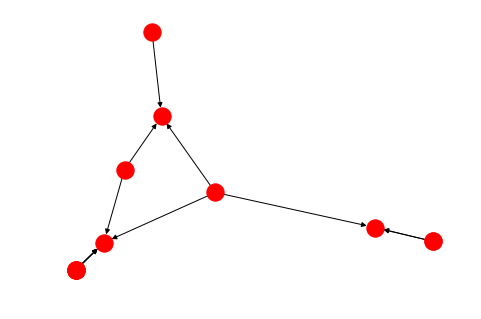

In [44]:
nx.draw_spectral(G)

As we did before, lets fit add all the edges (in l) into a Bayesian Model instance.

In [45]:
new_flags_model = BayesianModel(l)

In [46]:
new_flags_model.nodes()

NodeView(('sunstars', 'religion', 'crescent', 'red', 'saltires', 'language', 'blue', 'white', 'landmass', 'green', 'gold', 'black'))

In [47]:
new_flags_model.edges()

OutEdgeView([('sunstars', 'religion'), ('crescent', 'religion'), ('red', 'religion'), ('red', 'language'), ('red', 'landmass'), ('saltires', 'language'), ('blue', 'language'), ('white', 'language'), ('green', 'landmass'), ('green', 'language'), ('gold', 'landmass'), ('black', 'language')])

Now we fit the data using MLE for parameter learning and show the CPDs table as a list:

In [48]:
mle = MaximumLikelihoodEstimator(new_flags_model, xTrain)
new_flags_model.fit(xTrain, estimator=MaximumLikelihoodEstimator)

In [49]:
new_flags_model.get_cpds()

[<TabularCPD representing P(black:2) at 0x1c20764dd8>,
 <TabularCPD representing P(blue:2) at 0x1c20764ef0>,
 <TabularCPD representing P(crescent:2) at 0x1c20764e10>,
 <TabularCPD representing P(gold:2) at 0x1c2078e6d8>,
 <TabularCPD representing P(green:2) at 0x1c2078e160>,
 <TabularCPD representing P(landmass:6 | gold:2, green:2, red:2) at 0x1c20764f60>,
 <TabularCPD representing P(language:10 | black:2, blue:2, green:2, red:2, saltires:2, white:2) at 0x1c207982e8>,
 <TabularCPD representing P(red:2) at 0x1c20798e10>,
 <TabularCPD representing P(religion:8 | crescent:2, red:2, sunstars:5) at 0x1c20798240>,
 <TabularCPD representing P(saltires:2) at 0x1c20798d30>,
 <TabularCPD representing P(sunstars:5) at 0x1c20798c88>,
 <TabularCPD representing P(white:2) at 0x1c2078edd8>]

In [50]:
new_flags_model.local_independencies('religion')

(religion _|_ landmass, saltires, gold, language, white, green, black, blue | crescent, sunstars, red)

Even though we only used a subset of the features from the original dataset, we are able to establish more complex causal relationships. Now, there are at least three nodes that have three or more variables as evidence. We will see that creating more complex causal relationshps and reducing the nodes from the previous graph has its advantages as well as disadvantages.

# Prediction and Inference on Bayesian Networks

There are many different types of questions we can ask for Bayesian Networks, but we will study the following: conditional probability queries.

There are two types of inference methods used for Graphical Models: <br>
1. Exact Inference
2. Approximate Inference

Exact inference algorithms can give the precise results of a query; approximate inference algorithms does not perform exact computations but rather search for reasonable computational work, usually via stochastic simulations and sampling methods. <br> <br>
We proceed by using an exact inference algorithm called Variable Elimination. There are really two simple reasons as to why I chose to this: Variable Elimination is the most supported exact inference algorithm in pgmpy, and when I tested the computation, it completed within minutes at max. Exact inference is feasible on the new and old flags Bayesian Network models.

In [51]:
flags_infer = VariableElimination(new_flags_model)
print("done") #done quickly

done


This is an example of making a query for the __marginal distribution__ of religion: <br> <br>
For reference, here are the encodings of religion: <br>
religion: 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others 

In [52]:
religion_conditional_dist = flags_infer.query(['religion'])
print(religion_conditional_dist)

Eliminating: blue: 100%|██████████| 11/11 [00:00<00:00, 142.88it/s]

+-------------+-----------------+
| religion    |   phi(religion) |
+=============+=================+
| religion(0) |          0.1874 |
+-------------+-----------------+
| religion(1) |          0.2883 |
+-------------+-----------------+
| religion(2) |          0.1966 |
+-------------+-----------------+
| religion(3) |          0.0454 |
+-------------+-----------------+
| religion(4) |          0.0142 |
+-------------+-----------------+
| religion(5) |          0.1567 |
+-------------+-----------------+
| religion(6) |          0.0819 |
+-------------+-----------------+
| religion(7) |          0.0294 |
+-------------+-----------------+


It is evident that the probability of observing flags from countries of Catholic, other Christian, and Muslim religions is higher than the probability of observing flags from countries of other religions.

This is an example of making a query for the __conditional distribution table__ of religion: <br>
We ask: $P(religion | crescent = 1)$, or the conditional probability distribution of religion given that a flag has a crescent.

In [53]:
print(flags_infer.query(['religion'], evidence={'crescent': 1}))

Eliminating: blue: 100%|██████████| 10/10 [00:00<00:00, 143.94it/s]

+-------------+-----------------+
| religion    |   phi(religion) |
+=============+=================+
| religion(0) |          0.0214 |
+-------------+-----------------+
| religion(1) |          0.0214 |
+-------------+-----------------+
| religion(2) |          0.7144 |
+-------------+-----------------+
| religion(3) |          0.1050 |
+-------------+-----------------+
| religion(4) |          0.0316 |
+-------------+-----------------+
| religion(5) |          0.0214 |
+-------------+-----------------+
| religion(6) |          0.0632 |
+-------------+-----------------+
| religion(7) |          0.0214 |
+-------------+-----------------+


We see that $P(religion | crescent = 1)$ is highest for flags of Muslim countries. This is something that reaffirms  prior knowledge; the crescent is a traditional symbol of Islam since the Ottoman Empire.

In [54]:
print(flags_infer.query(['language'], evidence={'green': 1, 'red': 1, 'black': 1, 'white': 1}))

Eliminating: crescent: 100%|██████████| 7/7 [00:00<00:00, 247.68it/s]

+--------------+-----------------+
| language     |   phi(language) |
+==============+=================+
| language(1)  |          0.3795 |
+--------------+-----------------+
| language(2)  |          0.1518 |
+--------------+-----------------+
| language(3)  |          0.0039 |
+--------------+-----------------+
| language(4)  |          0.0039 |
+--------------+-----------------+
| language(5)  |          0.0039 |
+--------------+-----------------+
| language(6)  |          0.0039 |
+--------------+-----------------+
| language(7)  |          0.0039 |
+--------------+-----------------+
| language(8)  |          0.3101 |
+--------------+-----------------+
| language(9)  |          0.0039 |
+--------------+-----------------+
| language(10) |          0.1351 |
+--------------+-----------------+


We see that the conditional probability table values of religion given a flag has the colors green, red, black, and white is highest for Arabic and English languages. This reaffirms knowledge of Arabic-speaking countries' flags.

In [55]:
print(flags_infer.query(['landmass'], evidence={'red': 1, 'green': 1, 'gold': 1}))

Eliminating: blue: 100%|██████████| 8/8 [00:00<00:00, 254.67it/s]

+-------------+-----------------+
| landmass    |   phi(landmass) |
+=============+=================+
| landmass(1) |          0.2222 |
+-------------+-----------------+
| landmass(2) |          0.1111 |
+-------------+-----------------+
| landmass(3) |          0.0833 |
+-------------+-----------------+
| landmass(4) |          0.5000 |
+-------------+-----------------+
| landmass(5) |          0.0278 |
+-------------+-----------------+
| landmass(6) |          0.0556 |
+-------------+-----------------+


We see that the conditional probability table values of landmass given a flag has the colors red, green, gold is highest for African countries, which also reaffirms previous knowledge.

Now we ask: $P(religion | sunstars = c, sunstars = d, sunstars = e, red = 1)$, or in words, the conditional probability distribution of religion given that a flag has 2 or more stars and the color red.

In [56]:
print(flags_infer.query(['religion'], evidence={'sunstars': 'c', 'sunstars': 'd', 'sunstars': 'e', 'red': 1}))

Eliminating: blue: 100%|██████████| 9/9 [00:00<00:00, 204.22it/s]

+-------------+-----------------+
| religion    |   phi(religion) |
+=============+=================+
| religion(0) |          0.0079 |
+-------------+-----------------+
| religion(1) |          0.9444 |
+-------------+-----------------+
| religion(2) |          0.0079 |
+-------------+-----------------+
| religion(3) |          0.0079 |
+-------------+-----------------+
| religion(4) |          0.0079 |
+-------------+-----------------+
| religion(5) |          0.0079 |
+-------------+-----------------+
| religion(6) |          0.0079 |
+-------------+-----------------+
| religion(7) |          0.0079 |
+-------------+-----------------+


We see that the probabilty of $P(religion=1 | sunstars = c, sunstars = d, sunstars = e, red = 1)$ is very high (~95%). I actually expected that religion 6, marxist, would be highest for this query. There are many explanations for why we did not see what we expected to: <br>
1. The small training set means that the prevalence of Christian religions skews computing other relations for religion
2. We have overfitted our model by specifying too complex causal relationships given a small training set
3. The query is too focused
4. Intuitive errors in defining causal relationships or the discretization process
<br> and the list can go on...

Now, let us see if we can make predictions on 'new data'. I say this with caution because a data example in our testing set might still be identical to one in our training set (especially given that the dataset is small and we only use a subset of it for our new flags model), such that we are not actually making a prediction on a newly observed data instance. Regardless, we will try and 'predict' the landmass, language, and religion for each new data in xTest:

In [57]:
xTest_subset = xTest.loc[:, ['sunstars', 'religion', 'crescent', 'red', 'saltires', 'language', 'blue', 'white', 'landmass', 'green', 'gold', 'black']]

In [58]:
predict_religion_correct = 0
predict_landmass_correct = 0
predict_language_correct = 0

for row in xTest_subset.values: 
    labels = {}
    evidence = {}
    evidence['sunstars'] = row[0]
    labels['religion'] = row[1]
    evidence['crescent'] = row[2]
    evidence['red'] = row[3]
    evidence['saltires'] = row[4]
    labels['language'] = row[5]
    evidence['blue'] = row[6]
    evidence['white'] = row[7]
    labels['landmass'] = row[8]
    evidence['green'] = row[9]
    evidence['gold'] = row[10]
    evidence['black'] = row[11]
    if ((flags_infer.map_query(['religion'], evidence))['religion'] == labels['religion']): predict_religion_correct += 1
    if ((flags_infer.map_query(['landmass'], evidence))['landmass'] == labels['landmass']): predict_landmass_correct += 1
    if ((flags_infer.map_query(['language'], evidence))['language'] == labels['language']): predict_language_correct += 1
    

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 583.11it/s]


Eliminating: landmass: 100%|██████████| 2/2 [00:00<00:00, 696.61it/s]


In [59]:
predict_religion_correct

6

In [60]:
predict_landmass_correct

2

In [61]:
predict_language_correct

8

So, our predictions were not that great, given we had a testing set of 20 examples. Again, as I mentioned before this can be due to so many factors: interpretation of prior knowledge, defining incorrect or too restrictive causal relationships, bias in discretization, small training and testing sets, nuances in parameter learning, etc.

# Concluding Remarks

The goal of this tutorial was to introduce the mathematical and statistical notions behind Bayesian Networks, as well as experiement with various tools such as structure learning, parameter learning, inference, etc. We have used pgmpy as this appeared to be the best tool for introductory applications.

# Further Resources and References

Pgmpy Documentation: http://pgmpy.org <br>
UCI ML Repository Flags Data Set: https://archive.ics.uci.edu/ml/datasets/Flags <br>
Recap of Probablity Concepts: http://tinyheero.github.io/2016/03/20/basic-prob.html <br>
Research on Flags Patterns: https://blogs.proquest.com/culturegrams/identifying-patterns-why-do-some-flags-look-similar/ <br>
Introduction to Probabilistic Graphical Models: https://sailinglab.github.io/pgm-spring-2019/notes/lecture-01/ <br>
Bayesian Network Conditional Independence: https://sailinglab.github.io/pgm-spring-2019/notes/lecture-02/ <br>
Bayesian Network Learning: http://www.cs.cmu.edu/~awm/15781/slides/Param_Struct_Learning05v1.pdf & https://www.cs.cmu.edu/~dmarg/Papers/PhD-Thesis-Margaritis.pdf <br>
Bayesian Network Inference: https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-825-techniques-in-artificial-intelligence-sma-5504-fall-2002/lecture-notes/Lecture16FinalPart1.pdf & http://slazebni.cs.illinois.edu/fall17/lec15_bayes_net_inference.pdf <br>